In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# İl ve İlçeleri İstasyonlarla Eşleştirme

In [2]:
il_shp = gpd.read_file("../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Il_Sinirlari_Polygon.shp")
il_shp = il_shp.to_crs(epsg=4326)
il_shp['centroid'] = il_shp.centroid
il_shp['centroid'] = il_shp['centroid'].to_crs(epsg=4326)
il_shp.head()

,il,geometry,centroid
0,Nigde,"POLYGON ((35.04489 37.98317, 35.03833 37.98151...",POINT (34.54969 37.98591)
1,Konya,"POLYGON ((34.41157 37.35142, 34.39887 37.34340...",POINT (32.81806 37.94680)
2,Mersin,"POLYGON ((34.44162 37.32155, 34.44804 37.32087...",POINT (34.45290 37.29713)
3,Karaman,"POLYGON ((34.28436 37.22108, 34.27774 37.21775...",POINT (33.47320 37.26002)
4,Mersin,"POLYGON ((34.14111 37.19009, 34.13561 37.19010...",POINT (34.02366 37.10653)


In [3]:
ilce_shp = gpd.read_file("../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Ilce_Sinirlari_Polygon.shp")
ilce_shp = ilce_shp.to_crs(epsg=4326)
ilce_shp['centroid'] = ilce_shp.centroid
ilce_shp['centroid'] = ilce_shp['centroid'].to_crs(epsg=4326)
ilce_shp.head()

,ilce,geometry,centroid
0,Nigde_Merkez,"POLYGON ((35.04489 37.98317, 35.04088 37.98216...",POINT (34.74732 38.10945)
1,Camardi,"POLYGON ((34.86361 37.94323, 34.86529 37.93813...",POINT (34.85741 37.91865)
2,Bor,"POLYGON ((34.85726 37.85531, 34.85031 37.84722...",POINT (34.45304 37.85566)
3,Ulukisla,"POLYGON ((34.62206 37.68925, 34.61587 37.68602...",POINT (34.43086 37.57908)
4,Camliyayla,"POLYGON ((34.50508 37.37900, 34.49775 37.37649...",POINT (34.48395 37.37540)


In [4]:
istasyonlar = gpd.read_file("../input/mgm-meteorolojik-dzenlenmi/mygeodata/Ads-z_Proje-point.shp")
istasyonlar = istasyonlar.drop(columns=["descriptio", "altitudeMo"])
istasyonlar

,Name,geometry
0,Konya_B,POINT (32.47130 37.86870)
1,Beysehir,POINT (31.74630 37.67770)
2,Kulu,POINT (33.06570 39.07880)
3,Eregli,POINT (34.04850 37.52550)
4,Konya_H,POINT (32.57400 37.98370)
5,Hadim,POINT (32.45570 36.98930)
6,Ilgin,POINT (31.89400 38.27630)
7,Cumra,POINT (32.79000 37.56580)
8,Karapinar,POINT (33.52600 37.71631)
9,Seydisehir,POINT (31.85380 37.44960)


In [5]:
m = folium.Map(location= (37.86849369999999, 32.471403), zoom_start=8)
folium.GeoJson(data= il_shp["geometry"]).add_to(m)
for i, p in il_shp.iterrows():
    folium.Marker(location = [p.centroid.xy[1][0], p.centroid.xy[0][0]], popup = p.il, 
                  icon = folium.Icon(color = "%s" % "pink")).add_to(m)
for i,p in istasyonlar.iterrows():
    folium.Marker(location = [p.geometry.xy[1][0], p.geometry.xy[0][0]], popup = p.Name, 
                  icon = folium.Icon(color = "%s" % "green")).add_to(m)
m

Ilgın - Kadınhanı - Saraöynü ve Hadim istasyonları Havza Dışında

Bu yüzden bu istasyonları veriden atalım Fakat eksik veride kullanabilmemiz için bu verileri de saklayalım

In [6]:
distname = istasyonlar["Name"].tolist()
distname

['Konya_B',
 'Beysehir',
 'Kulu',
 'Eregli',
 'Konya_H',
 'Hadim',
 'Ilgin',
 'Cumra',
 'Karapinar',
 'Seydisehir',
 'Sarayonu',
 'Kadinhani',
 'Aksaray',
 'Karaman',
 'Nigde']

In [7]:
yakin_ist_list = []
coord_ist_list = []
for i in il_shp.T:
    distlist = []
    for j in istasyonlar.T:
        distlist.append(il_shp.iloc[i]["centroid"].distance(istasyonlar.iloc[j]["geometry"]))
        
    minimum = distlist[0]
    for i in distlist:
        if minimum > i:
            minimum = i

    index = distlist.index(minimum)
    yakin_ist_list.append(distname[index])
    coord_ist_list.append(istasyonlar["geometry"][index])
    
il_shp["yakin_ist"] = yakin_ist_list
il_shp["coord_ist"] = coord_ist_list

il_shp

,il,geometry,centroid,yakin_ist,coord_ist
0,Nigde,"POLYGON ((35.04489 37.98317, 35.03833 37.98151...",POINT (34.54969 37.98591),Nigde,POINT (34.6795 37.9585)
1,Konya,"POLYGON ((34.41157 37.35142, 34.39887 37.34340...",POINT (32.81806 37.94680),Konya_H,POINT (32.574 37.9837)
2,Mersin,"POLYGON ((34.44162 37.32155, 34.44804 37.32087...",POINT (34.45290 37.29713),Eregli,POINT (34.0485 37.5255)
3,Karaman,"POLYGON ((34.28436 37.22108, 34.27774 37.21775...",POINT (33.47320 37.26002),Karaman,POINT (33.2202 37.1932)
4,Mersin,"POLYGON ((34.14111 37.19009, 34.13561 37.19010...",POINT (34.02366 37.10653),Eregli,POINT (34.0485 37.5255)
5,Mersin,"POLYGON ((33.71372 37.02449, 33.71182 37.01303...",POINT (33.56222 36.97993),Karaman,POINT (33.2202 37.1932)
6,Antalya,"POLYGON ((32.00269 37.08952, 31.99757 37.09001...",POINT (31.96920 37.11357),Seydisehir,POINT (31.8538 37.4496)
7,Antalya,"POLYGON ((31.86966 37.23659, 31.86949 37.23662...",POINT (31.85267 37.25813),Seydisehir,POINT (31.8538 37.4496)
8,Antalya,"POLYGON ((31.81432 37.31645, 31.81197 37.31807...",POINT (31.72582 37.33993),Seydisehir,POINT (31.8538 37.4496)
9,Antalya,"POLYGON ((31.52532 37.33275, 31.52295 37.33075...",POINT (31.44808 37.32176),Seydisehir,POINT (31.8538 37.4496)


In [8]:
il_shp.il = il_shp.il + "_il"
il_shp

,il,geometry,centroid,yakin_ist,coord_ist
0,Nigde_il,"POLYGON ((35.04489 37.98317, 35.03833 37.98151...",POINT (34.54969 37.98591),Nigde,POINT (34.6795 37.9585)
1,Konya_il,"POLYGON ((34.41157 37.35142, 34.39887 37.34340...",POINT (32.81806 37.94680),Konya_H,POINT (32.574 37.9837)
2,Mersin_il,"POLYGON ((34.44162 37.32155, 34.44804 37.32087...",POINT (34.45290 37.29713),Eregli,POINT (34.0485 37.5255)
3,Karaman_il,"POLYGON ((34.28436 37.22108, 34.27774 37.21775...",POINT (33.47320 37.26002),Karaman,POINT (33.2202 37.1932)
4,Mersin_il,"POLYGON ((34.14111 37.19009, 34.13561 37.19010...",POINT (34.02366 37.10653),Eregli,POINT (34.0485 37.5255)
5,Mersin_il,"POLYGON ((33.71372 37.02449, 33.71182 37.01303...",POINT (33.56222 36.97993),Karaman,POINT (33.2202 37.1932)
6,Antalya_il,"POLYGON ((32.00269 37.08952, 31.99757 37.09001...",POINT (31.96920 37.11357),Seydisehir,POINT (31.8538 37.4496)
7,Antalya_il,"POLYGON ((31.86966 37.23659, 31.86949 37.23662...",POINT (31.85267 37.25813),Seydisehir,POINT (31.8538 37.4496)
8,Antalya_il,"POLYGON ((31.81432 37.31645, 31.81197 37.31807...",POINT (31.72582 37.33993),Seydisehir,POINT (31.8538 37.4496)
9,Antalya_il,"POLYGON ((31.52532 37.33275, 31.52295 37.33075...",POINT (31.44808 37.32176),Seydisehir,POINT (31.8538 37.4496)


In [9]:
m = folium.Map(location= (37.86849369999999, 32.471403), zoom_start=8)
folium.GeoJson(data= il_shp["geometry"]).add_to(m)
for i, p in il_shp.iterrows():
    folium.Marker(location = [p.centroid.xy[1][0], p.centroid.xy[0][0]], popup = "İl: "+p.il+"\nİst: "+p.yakin_ist, 
                  icon = folium.Icon(color = "%s" % "pink")).add_to(m)
for i,p in istasyonlar.iterrows():
    folium.Marker(location = [p.geometry.xy[1][0], p.geometry.xy[0][0]], popup = "İst: "+p.Name, 
                  icon = folium.Icon(color = "%s" % "green")).add_to(m)
m

In [10]:
c_il_shp = il_shp.drop(columns=["geometry", "centroid", "coord_ist"])
c_il_shp

,il,yakin_ist
0,Nigde_il,Nigde
1,Konya_il,Konya_H
2,Mersin_il,Eregli
3,Karaman_il,Karaman
4,Mersin_il,Eregli
5,Mersin_il,Karaman
6,Antalya_il,Seydisehir
7,Antalya_il,Seydisehir
8,Antalya_il,Seydisehir
9,Antalya_il,Seydisehir


In [11]:
for i,r in c_il_shp.iterrows():
    if c_il_shp.il[i] == "Mersin_il":
        r.yakin_ist = "Karaman"
    elif c_il_shp.il[i] == "Konya_il":
        r.yakin_ist = "KONYA_ORT"

In [12]:
c_il_shp = c_il_shp.rename(columns={"il":"yer"})
c_il_shp = c_il_shp.drop_duplicates(ignore_index=True)
c_il_shp

,yer,yakin_ist
0,Nigde_il,Nigde
1,Konya_il,KONYA_ORT
2,Mersin_il,Karaman
3,Karaman_il,Karaman
4,Antalya_il,Seydisehir
5,Isparta_il,Beysehir
6,Ankara_il,Kulu
7,Aksaray_il,Aksaray
8,Nevsehir_il,Nigde


In [13]:
yakin_ist_list = []
coord_ist_list = []
for i in ilce_shp.T:
    distlist = []
    for j in istasyonlar.T:
        distlist.append(ilce_shp.iloc[i]["centroid"].distance(istasyonlar.iloc[j]["geometry"]))
        
    minimum = distlist[0]
    for i in distlist:
        if minimum > i:
            minimum = i

    index = distlist.index(minimum)
    yakin_ist_list.append(distname[index])
    coord_ist_list.append(istasyonlar["geometry"][index])
    
ilce_shp["yakin_ist"] = yakin_ist_list
ilce_shp["coord_ist"] = coord_ist_list

ilce_shp.head()

,ilce,geometry,centroid,yakin_ist,coord_ist
0,Nigde_Merkez,"POLYGON ((35.04489 37.98317, 35.04088 37.98216...",POINT (34.74732 38.10945),Nigde,POINT (34.6795 37.9585)
1,Camardi,"POLYGON ((34.86361 37.94323, 34.86529 37.93813...",POINT (34.85741 37.91865),Nigde,POINT (34.6795 37.9585)
2,Bor,"POLYGON ((34.85726 37.85531, 34.85031 37.84722...",POINT (34.45304 37.85566),Nigde,POINT (34.6795 37.9585)
3,Ulukisla,"POLYGON ((34.62206 37.68925, 34.61587 37.68602...",POINT (34.43086 37.57908),Eregli,POINT (34.0485 37.5255)
4,Camliyayla,"POLYGON ((34.50508 37.37900, 34.49775 37.37649...",POINT (34.48395 37.37540),Eregli,POINT (34.0485 37.5255)


In [14]:
m = folium.Map(location= (37.86849369999999, 32.471403), zoom_start=8)
folium.GeoJson(data= ilce_shp["geometry"]).add_to(m)
for i, p in ilce_shp.iterrows():
    folium.Marker(location = [p.centroid.xy[1][0], p.centroid.xy[0][0]], popup = "İlçe: "+p.ilce+"\nİst: "+p.yakin_ist, 
                  icon = folium.Icon(color = "%s" % "pink")).add_to(m)
for i,p in istasyonlar.iterrows():
    folium.Marker(location = [p.geometry.xy[1][0], p.geometry.xy[0][0]], popup = "İst: "+p.Name, 
                  icon = folium.Icon(color = "%s" % "green")).add_to(m)
m

In [15]:
c_ilce_shp = ilce_shp.drop(columns=["coord_ist"])
c_ilce_shp = c_ilce_shp.drop(columns=["geometry", "centroid"])
for i,r in c_ilce_shp.iterrows():
    if r.ilce == "Yalvac" or r.ilce == "Ilgin" or r.ilce == "Doganhisar":
        r.yakin_ist = "Beysehir"
    elif r.ilce == "Bozkir":
        r.yakin_ist = "Seydisehir"
    elif r.ilce == "Akoren":
        r.yakin_ist = "Cumra"
    elif r.ilce == "Derbent" or r.ilce == "Kadinhani" or r.ilce == "Sarayonu" or r.ilce == "Karatay" or r.yakin_ist == "Konya_B" or r.yakin_ist == "Konya_H":
        r.yakin_ist = "Konya"
        
c_ilce_shp = c_ilce_shp.rename(columns={"ilce":"yer"})
c_ilce_shp = c_ilce_shp.drop_duplicates(ignore_index=True)
        
c_ilce_shp

,yer,yakin_ist
0,Nigde_Merkez,Nigde
1,Camardi,Nigde
2,Bor,Nigde
3,Ulukisla,Eregli
4,Camliyayla,Eregli
...,...,...
61,Akoren,Cumra
62,Yalihuyuk,Seydisehir
63,Meram,Konya
64,Karatay,Konya


In [16]:
c_ilce_shp.duplicated().sum()

0

In [17]:
for i,r in c_ilce_shp.iterrows():
    if r.yer == "Nigde_Merkez":
        print("Karaman Merkez oldu")
        c_ilce_shp["yer"][i] = "Nigde"
    elif r.yer == "Aksaray_Merkez":
        print("Karaman Merkez oldu")
        c_ilce_shp["yer"][i] = "Aksaray"
    elif r.yer == "Nevsehir_Merkez":
        print("Karaman Merkez oldu")
        c_ilce_shp["yer"][i] = "Nevsehir"

Karaman Merkez oldu
Karaman Merkez oldu
Karaman Merkez oldu


Şimdi il-ilçeleri birleştirelim ve toplu istasyon verisi elde edelim.

In [18]:
yer_df = pd.concat([c_il_shp, c_ilce_shp])
yer_df = yer_df.append({"yer":"Havza", "yakin_ist":"HAVZA_ORT"}, ignore_index=True)
yer_df

,yer,yakin_ist
0,Nigde_il,Nigde
1,Konya_il,KONYA_ORT
2,Mersin_il,Karaman
3,Karaman_il,Karaman
4,Antalya_il,Seydisehir
...,...,...
71,Yalihuyuk,Seydisehir
72,Meram,Konya
73,Karatay,Konya
74,Altinekin,Konya


In [19]:
yer_df.drop_duplicates(inplace=True)
yer_df

,yer,yakin_ist
0,Nigde_il,Nigde
1,Konya_il,KONYA_ORT
2,Mersin_il,Karaman
3,Karaman_il,Karaman
4,Antalya_il,Seydisehir
...,...,...
71,Yalihuyuk,Seydisehir
72,Meram,Konya
73,Karatay,Konya
74,Altinekin,Konya


In [20]:
yer_df[yer_df.duplicated()]

,yer,yakin_ist


# Verilerin Bir Araya Getirilmesi

In [21]:
ndvi_df = pd.read_csv("../input/2204-d-ndvi-g-r-nt-leri-csv-ye-evirme/NDVI_Degerler_2000_2021.csv")
ndvi_df = ndvi_df.drop(columns="Unnamed: 0")
ndvi_df

,yer,yıl,ort,std,kat1,kat2,kat3
0,Havza,2013,0.142406,0.089892,83.460978,15.849318,0.689704
1,Havza,2014,0.137440,0.087038,82.974731,16.656456,0.368813
2,Havza,2015,0.145719,0.087256,82.065228,17.313620,0.621152
3,Havza,2016,0.143232,0.103975,83.036858,15.607313,1.355829
4,Havza,2017,0.171333,0.098933,71.907482,27.255065,0.837452
...,...,...,...,...,...,...,...
1579,Mut,2011,0.093986,0.015203,99.997313,0.002687,0.000000
1580,Toroslar,2011,0.096852,0.023959,99.960830,0.039170,0.000000
1581,Sultanhani,2011,0.079294,0.056371,96.059978,3.926262,0.013760
1582,Guzelyurt,2011,0.114842,0.055777,92.318737,7.680925,0.000338


In [22]:
yer_df[yer_df.yer=="Mersin_il"]

,yer,yakin_ist
2,Mersin_il,Karaman


In [23]:
yakin_ist_list = []
key = []
for i, r in ndvi_df.iterrows():
    for j, k in yer_df.iterrows():
        if r["yer"] == k["yer"]:
            key.append(r["yer"])
            yakin_ist_list.append(k["yakin_ist"])
            
        continue
                
        
ndvi_df["ist"] = yakin_ist_list

In [24]:
ndvi_df

,yer,yıl,ort,std,kat1,kat2,kat3,ist
0,Havza,2013,0.142406,0.089892,83.460978,15.849318,0.689704,HAVZA_ORT
1,Havza,2014,0.137440,0.087038,82.974731,16.656456,0.368813,HAVZA_ORT
2,Havza,2015,0.145719,0.087256,82.065228,17.313620,0.621152,HAVZA_ORT
3,Havza,2016,0.143232,0.103975,83.036858,15.607313,1.355829,HAVZA_ORT
4,Havza,2017,0.171333,0.098933,71.907482,27.255065,0.837452,HAVZA_ORT
...,...,...,...,...,...,...,...,...
1579,Mut,2011,0.093986,0.015203,99.997313,0.002687,0.000000,Karaman
1580,Toroslar,2011,0.096852,0.023959,99.960830,0.039170,0.000000,Eregli
1581,Sultanhani,2011,0.079294,0.056371,96.059978,3.926262,0.013760,Aksaray
1582,Guzelyurt,2011,0.114842,0.055777,92.318737,7.680925,0.000338,Aksaray


In [25]:
mgm_df = pd.read_csv("../input/jupyterdemeteorolojik-regresoyn/meteorolojik.csv")
mgm_df.drop(columns=["Unnamed: 0"], inplace=True)
mgm_df

,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag,yıl,ist
0,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,2000,Aksaray
1,20.191667,13.875000,7.666667,37.3,-13.8,17.2,260.6,2001,Aksaray
2,18.008333,11.650000,5.691667,37.5,-20.3,20.0,304.4,2002,Aksaray
3,18.366667,12.408333,6.708333,36.2,-12.5,18.0,198.8,2003,Aksaray
4,18.400000,12.150000,5.991667,36.0,-18.2,29.8,323.1,2004,Aksaray
...,...,...,...,...,...,...,...,...,...
259,18.966667,12.275000,5.983333,37.5,-19.0,25.4,240.5,2017,Niğde
260,19.875000,13.475000,7.508333,36.2,-12.6,23.0,400.3,2018,Niğde
261,18.858333,12.333333,6.441667,38.5,-15.9,25.0,305.4,2019,Niğde
262,19.545833,12.783333,6.487500,37.3,-16.1,19.9,219.5,2020,Niğde


In [26]:
mgm_df.ist.drop_duplicates()

0         Aksaray
22       Beysehir
44          Çumra
66         Ereğli
88      Havza Ort
110       Karaman
132     Karapınar
154     Konya Ort
176         Konya
198          Kulu
220    Seydişehir
242         Niğde
Name: ist, dtype: object

In [27]:
aks_df = mgm_df[mgm_df.ist == "Aksaray"]
bey_df = mgm_df[mgm_df.ist == "Beysehir"]
cum_df = mgm_df[mgm_df.ist == "Çumra"]
ere_df = mgm_df[mgm_df.ist == "Ereğli"]
hav_df = mgm_df[mgm_df.ist == "Havza Ort"]
krm_df = mgm_df[mgm_df.ist == "Karaman"]
krp_df = mgm_df[mgm_df.ist == "Karapınar"]
kon_df = mgm_df[mgm_df.ist == "Konya"]
kor_df = mgm_df[mgm_df.ist == "Konya Ort"]
kul_df = mgm_df[mgm_df.ist == "Kulu"]
nig_df = mgm_df[mgm_df.ist == "Niğde"]
sey_df = mgm_df[mgm_df.ist == "Seydişehir"]
aks_df

,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag,yıl,ist
0,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,2000,Aksaray
1,20.191667,13.875000,7.666667,37.3,-13.8,17.2,260.6,2001,Aksaray
2,18.008333,11.650000,5.691667,37.5,-20.3,20.0,304.4,2002,Aksaray
3,18.366667,12.408333,6.708333,36.2,-12.5,18.0,198.8,2003,Aksaray
4,18.400000,12.150000,5.991667,36.0,-18.2,29.8,323.1,2004,Aksaray
5,18.650000,12.541667,6.616667,37.4,-13.0,43.2,323.7,2005,Aksaray
6,18.700000,12.358333,6.100000,37.8,-18.6,24.8,301.5,2006,Aksaray
7,19.358333,12.766667,6.433333,38.0,-12.4,19.8,261.0,2007,Aksaray
8,18.841667,12.783333,6.933333,37.0,-18.6,40.5,405.2,2008,Aksaray
9,18.933333,13.008333,7.441667,34.0,-19.2,32.2,188.7,2009,Aksaray


In [28]:
cum_df

,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag,yıl,ist
44,18.016667,10.966667,18.016667,39.9,-20.0,45.4,332.0,2000,Çumra
45,20.166667,13.308333,20.166667,38.5,-12.0,23.6,334.6,2001,Çumra
46,18.091667,11.133333,18.091667,38.3,-21.8,23.2,248.2,2002,Çumra
47,18.316667,11.633333,18.316667,36.5,-14.6,26.2,204.0,2003,Çumra
48,18.916667,11.558333,18.916667,36.2,-20.0,44.0,412.2,2004,Çumra
49,19.108333,11.983333,19.108333,37.8,-16.8,18.4,245.2,2005,Çumra
50,18.983333,11.625000,18.983333,38.0,-22.5,26.8,288.6,2006,Çumra
51,19.425000,11.925000,19.425000,39.1,-21.1,38.4,375.6,2007,Çumra
52,19.233333,11.800000,19.233333,37.5,-19.0,44.6,443.6,2008,Çumra
53,19.291667,12.183333,19.291667,35.0,-20.2,23.8,342.6,2009,Çumra


In [29]:
ndviaks = ndvi_df[ndvi_df["ist"] == "Aksaray"].sort_values(by=["yıl"])
ndvibey = ndvi_df[ndvi_df["ist"] == "Beysehir"].sort_values(by=["yıl"])
ndvicum = ndvi_df[ndvi_df["ist"] == "Cumra"].sort_values(by=["yıl"])
ndviere = ndvi_df[ndvi_df["ist"] == "Eregli"].sort_values(by=["yıl"])
ndvihav = ndvi_df[ndvi_df["ist"] == "HAVZA_ORT"].sort_values(by=["yıl"])
ndvikrm = ndvi_df[ndvi_df["ist"] == "Karaman"].sort_values(by=["yıl"])
ndvikrp = ndvi_df[ndvi_df["ist"] == "Karapinar"].sort_values(by=["yıl"])
ndvikor = ndvi_df[ndvi_df["ist"] == "KONYA_ORT"].sort_values(by=["yıl"])
ndvikon = ndvi_df[ndvi_df["ist"] == "Konya"].sort_values(by=["yıl"])
ndvikul = ndvi_df[ndvi_df["ist"] == "Kulu"].sort_values(by=["yıl"])
ndvinig = ndvi_df[ndvi_df["ist"] == "Nigde"].sort_values(by=["yıl"])
ndvisey = ndvi_df[ndvi_df["ist"] == "Seydisehir"].sort_values(by=["yıl"])

ndviaks

,yer,yıl,ort,std,kat1,kat2,kat3,ist
834,Sultanhani,2000,0.084135,0.053374,95.961188,4.038812,0.000000,Aksaray
804,Acigol,2000,0.080301,0.028752,99.359200,0.640800,0.000000,Aksaray
815,Ortakoy,2000,0.109988,0.038453,96.899962,3.100038,0.000000,Aksaray
846,Guzelyurt,2000,0.108092,0.055019,92.829681,7.170319,0.000000,Aksaray
848,Gulagac,2000,0.089740,0.062419,93.006532,6.993468,0.000000,Aksaray
...,...,...,...,...,...,...,...,...
757,Guzelyurt,2021,0.125217,0.084094,88.239110,11.161493,0.599397,Aksaray
747,Aksaray,2021,0.104339,0.071412,93.034042,6.692498,0.273459,Aksaray
742,Agacoren,2021,0.104361,0.038184,97.184444,2.773448,0.042108,Aksaray
95,Aksaray_il,2021,0.128835,0.099221,86.812846,11.883997,1.303157,Aksaray


In [30]:
ndvibey

,yer,yıl,ort,std,kat1,kat2,kat3,ist
832,Doganhisar,2000,0.140313,0.041171,90.840700,9.159300,0.000000,Beysehir
807,Gelendost,2000,0.130240,0.021561,99.315872,0.684128,0.000000,Beysehir
818,Ilgin,2000,0.182113,0.065145,69.831032,30.168968,0.000000,Beysehir
819,Aksu,2000,0.145934,0.059864,81.043127,18.956873,0.000000,Beysehir
827,Beysehir,2000,0.166414,0.071613,70.705746,29.293801,0.000453,Beysehir
...,...,...,...,...,...,...,...,...
755,Egirdir,2021,0.189853,0.035759,70.813831,29.186169,0.000000,Beysehir
750,Doganhisar,2021,0.191627,0.042531,62.854993,37.145007,0.000000,Beysehir
748,Sutculer,2021,0.210062,0.047140,42.850120,57.149880,0.000000,Beysehir
94,Isparta_il,2021,0.191542,0.062531,58.978212,41.005384,0.016404,Beysehir


In [31]:
def param_column_adder(indf, outdf):
    allst = []
    yearlst = list(range(2000,2022))
    yearlst.remove(2012)
    for i in indf.drop(columns="yıl"):
        for year in yearlst:
            count_year = len(outdf[outdf["yıl"] == year])
            lst = list(indf.loc[indf["yıl"] == year][i])*count_year
            allst.extend(lst)
        outdf[i] = allst
        allst = []

In [32]:
param_column_adder(aks_df, ndviaks)
param_column_adder(bey_df, ndvibey)
param_column_adder(cum_df, ndvicum)
param_column_adder(ere_df, ndviere)
param_column_adder(hav_df, ndvihav)
param_column_adder(krm_df, ndvikrm)
param_column_adder(krp_df, ndvikrp)
param_column_adder(kor_df, ndvikor)
param_column_adder(kon_df, ndvikon)
param_column_adder(kul_df, ndvikul)
param_column_adder(nig_df, ndvinig)
param_column_adder(sey_df, ndvisey)

In [33]:
ndviaks

,yer,yıl,ort,std,kat1,kat2,kat3,ist,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag
834,Sultanhani,2000,0.084135,0.053374,95.961188,4.038812,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
804,Acigol,2000,0.080301,0.028752,99.359200,0.640800,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
815,Ortakoy,2000,0.109988,0.038453,96.899962,3.100038,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
846,Guzelyurt,2000,0.108092,0.055019,92.829681,7.170319,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
848,Gulagac,2000,0.089740,0.062419,93.006532,6.993468,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Guzelyurt,2021,0.125217,0.084094,88.239110,11.161493,0.599397,Aksaray,19.958333,13.466667,7.616667,38.4,-13.3,14.8,275.2
747,Aksaray,2021,0.104339,0.071412,93.034042,6.692498,0.273459,Aksaray,19.958333,13.466667,7.616667,38.4,-13.3,14.8,275.2
742,Agacoren,2021,0.104361,0.038184,97.184444,2.773448,0.042108,Aksaray,19.958333,13.466667,7.616667,38.4,-13.3,14.8,275.2
95,Aksaray_il,2021,0.128835,0.099221,86.812846,11.883997,1.303157,Aksaray,19.958333,13.466667,7.616667,38.4,-13.3,14.8,275.2


In [34]:
ndvikrm

,yer,yıl,ort,std,kat1,kat2,kat3,ist,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag
805,Mut,2000,0.110204,0.020229,99.570031,0.429969,0.000000,Karaman,18.141667,11.083333,4.333333,40.4,-18.2,34.4,263.4
821,Silifke,2000,0.103136,0.023145,99.279013,0.720987,0.000000,Karaman,18.141667,11.083333,4.333333,40.4,-18.2,34.4,263.4
836,Kazimkarabekir,2000,0.119347,0.063599,90.612932,9.387068,0.000000,Karaman,18.141667,11.083333,4.333333,40.4,-18.2,34.4,263.4
817,Karaman,2000,0.127640,0.071964,86.198233,13.801391,0.000376,Karaman,18.141667,11.083333,4.333333,40.4,-18.2,34.4,263.4
108,Mersin_il,2000,0.106971,0.030043,98.930588,1.069412,0.000000,Karaman,18.141667,11.083333,4.333333,40.4,-18.2,34.4,263.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Karaman_il,2021,0.134098,0.089468,89.129220,10.063869,0.806911,Karaman,19.966667,13.375000,7.158333,37.5,-12.2,21.4,253.0
800,Kazimkarabekir,2021,0.136729,0.086819,87.365286,12.488617,0.146097,Karaman,19.966667,13.375000,7.158333,37.5,-12.2,21.4,253.0
796,Mut,2021,0.113362,0.011351,99.957003,0.042997,0.000000,Karaman,19.966667,13.375000,7.158333,37.5,-12.2,21.4,253.0
761,Karaman,2021,0.142996,0.100772,84.939969,14.412478,0.647553,Karaman,19.966667,13.375000,7.158333,37.5,-12.2,21.4,253.0


In [35]:
ndviaks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 834 to 790
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yer         210 non-null    object 
 1   yıl         210 non-null    int64  
 2   ort         210 non-null    float64
 3   std         210 non-null    float64
 4   kat1        210 non-null    float64
 5   kat2        210 non-null    float64
 6   kat3        210 non-null    float64
 7   ist         210 non-null    object 
 8   ortmax_sic  210 non-null    float64
 9   ort_sic     210 non-null    float64
 10  ortmin_sic  210 non-null    float64
 11  max_sic     210 non-null    float64
 12  min_sic     210 non-null    float64
 13  max_yag     210 non-null    float64
 14  top_yag     210 non-null    float64
dtypes: float64(12), int64(1), object(2)
memory usage: 26.2+ KB


# Verilerin İncelenmesi

In [36]:
def plotsic(name, df):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
    p1 = sns.lineplot(x = "yıl", y = "max_sic", linewidth = 5, data = df, label = "Yıllık Maksimum Sıcaklık", color = "red", 
                      ax = axs[0])
    sns.lineplot(x = "yıl", y = "ort_sic", data = df, linewidth = 5, label = "Yıllık Ortalama Sıcaklık", color = "orange", 
                 ax = axs[2])
    sns.lineplot(x = "yıl", y = "min_sic", data = df, linewidth = 5, label = "Yıllık Minimum Sıcaklık", color = "yellow", 
                 ax = axs[4])
    sns.lineplot(x = "yıl", y = "ortmax_sic", data = df, linewidth = 5, label = "Yıllık Ortalama Maksimum Sıcaklık", 
                      color = "red", ax = axs[1])
    sns.lineplot(x = "yıl", y = "ortmin_sic", data = df, linewidth = 5, label = "Yıllık Ortalama Minimum Sıcaklık", 
                 color = "yellow", ax = axs[3])

    fig.suptitle("{} İstasyonuna Ait Sıcaklık Değerleri".format(name), fontsize=20)
    p1.set_ylabel("Sıcaklık (°C)", fontsize=15)
    sns.despine()
    plt.show()

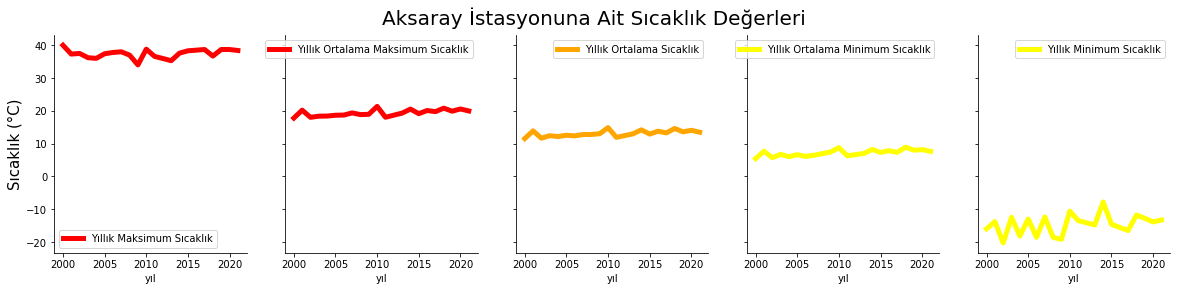

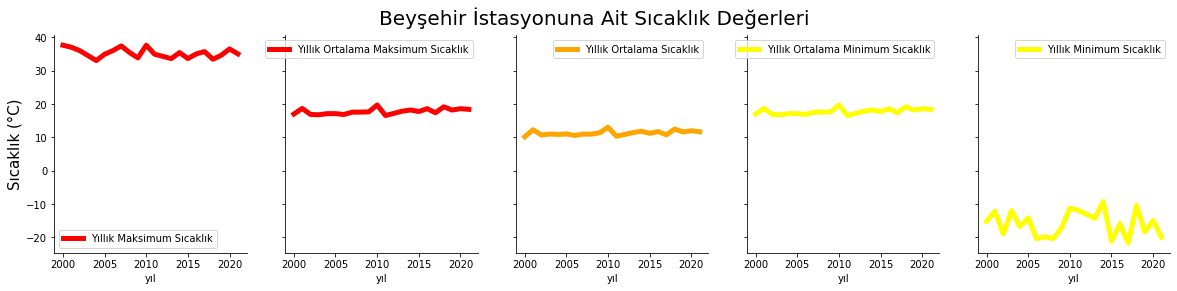

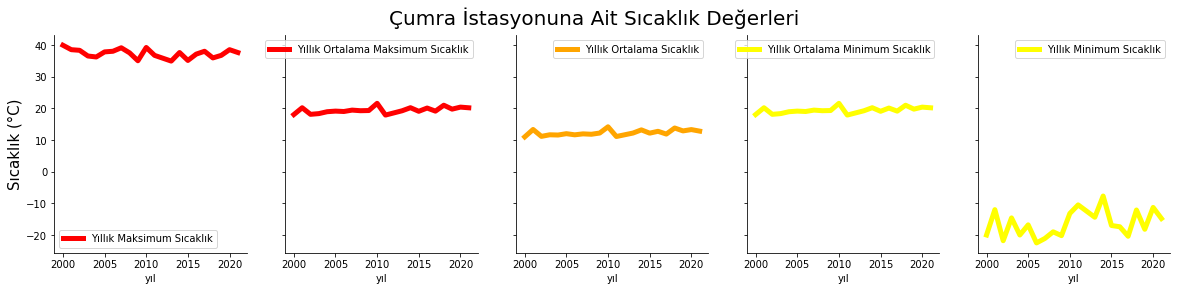

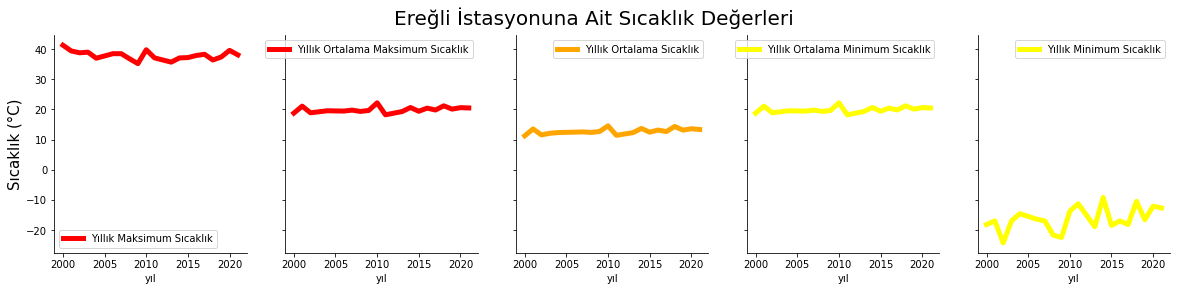

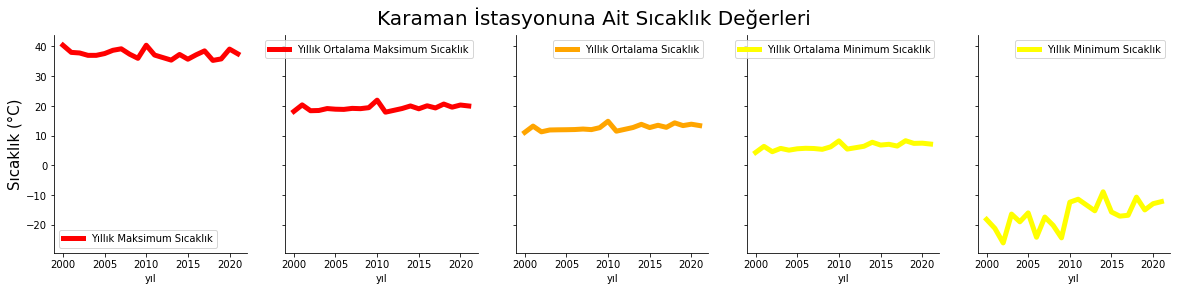

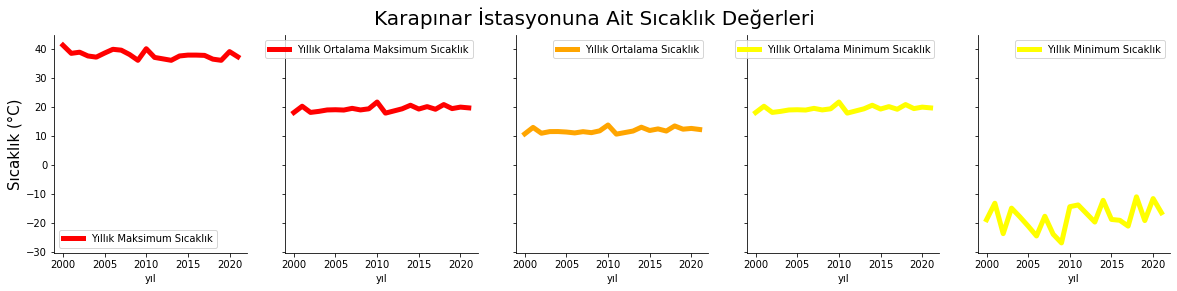

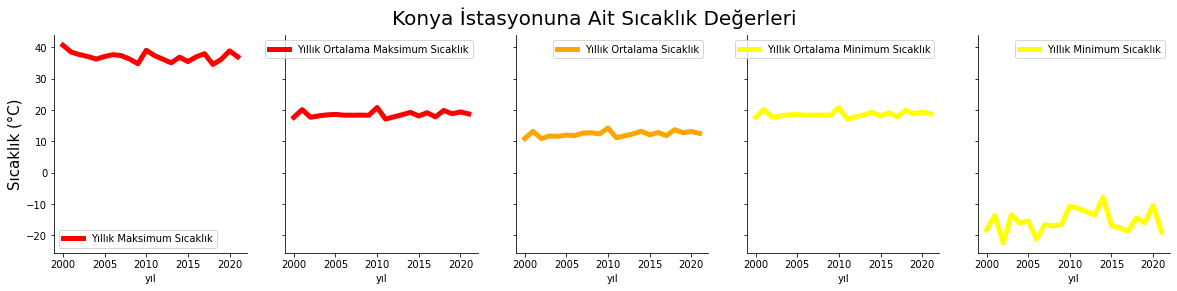

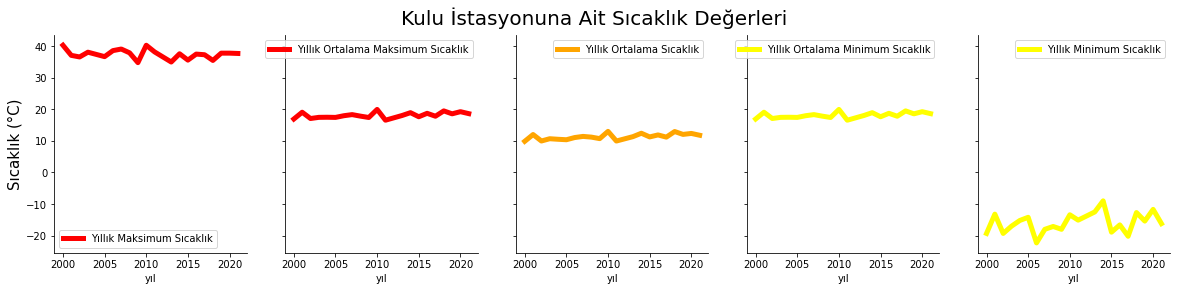

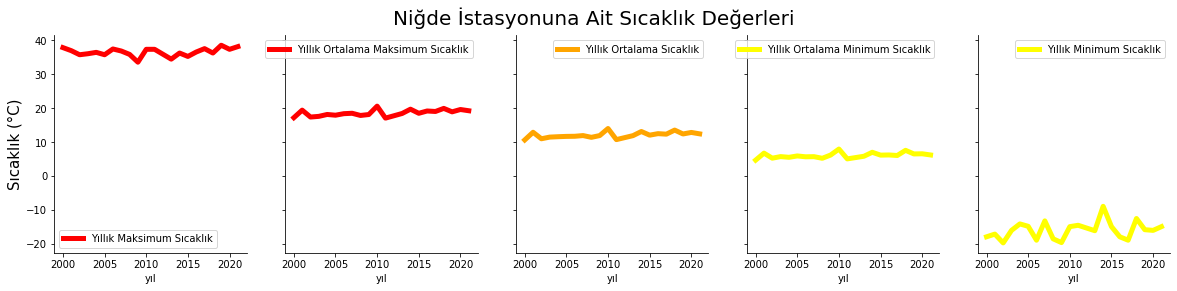

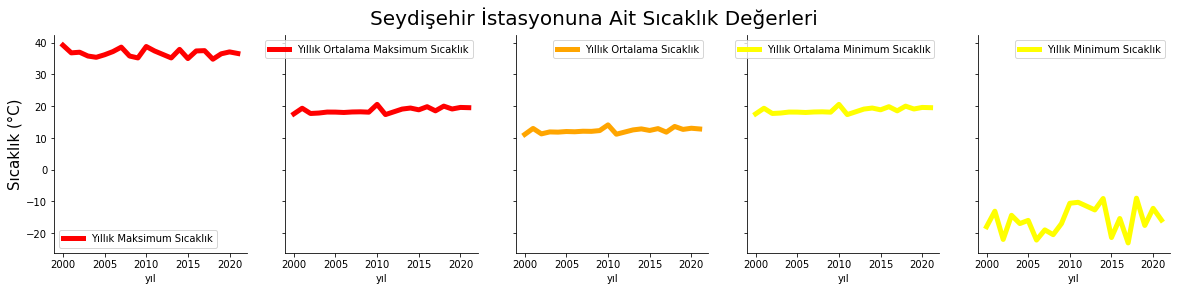

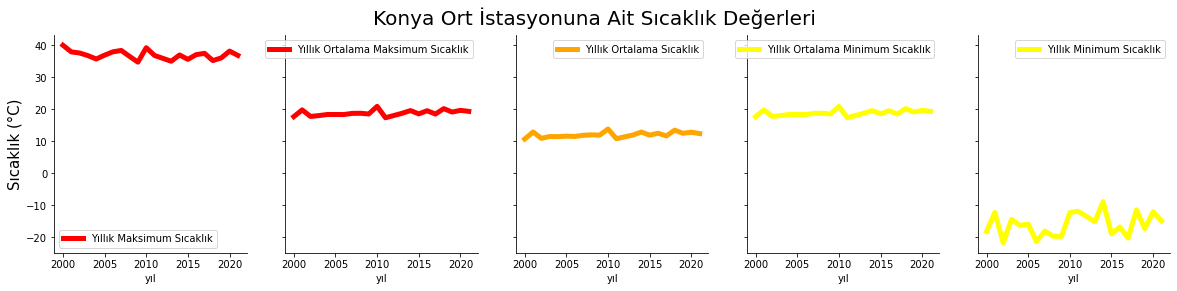

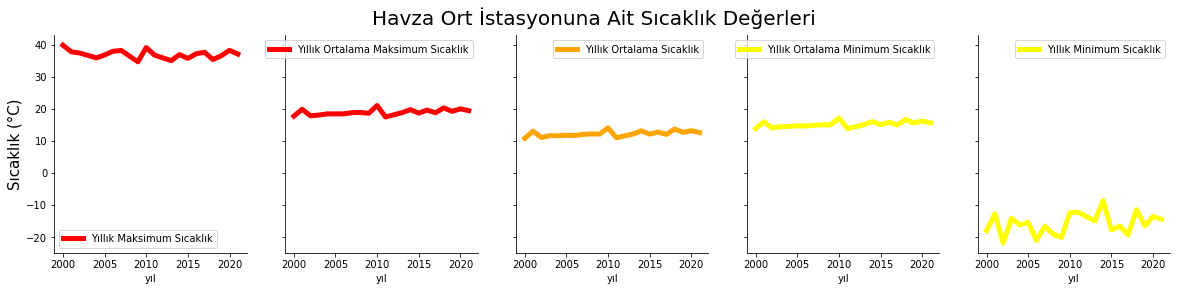

In [37]:
plotsic("Aksaray", ndviaks)
plotsic("Beyşehir", ndvibey)
plotsic("Çumra", ndvicum)
plotsic("Ereğli", ndviere)
plotsic("Karaman", ndvikrm)
plotsic("Karapınar", ndvikrp)
plotsic("Konya", ndvikon)
plotsic("Kulu", ndvikul)
plotsic("Niğde", ndvinig)
plotsic("Seydişehir", ndvisey)
plotsic("Konya Ort", ndvikor)
plotsic("Havza Ort", ndvihav)

In [38]:
def plotyag(name, df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
    p1 = sns.lineplot(x = "yıl", y = "max_yag", linewidth = 5, data = df, label = "Yıllık Maksimum Sıcaklık", color = "blue", 
                      ax = axs[0])
    sns.lineplot(x = "yıl", y = "top_yag", data = df, linewidth = 5, label = "Yıllık Ortalama Sıcaklık", color = "dodgerblue", 
                 ax = axs[1])

    fig.suptitle("{} İstasyonuna Ait Yağış Değerleri".format(name), fontsize=20)
    p1.set_ylabel("Sıcaklık (°C)", fontsize=15)
    sns.despine()
    plt.show()

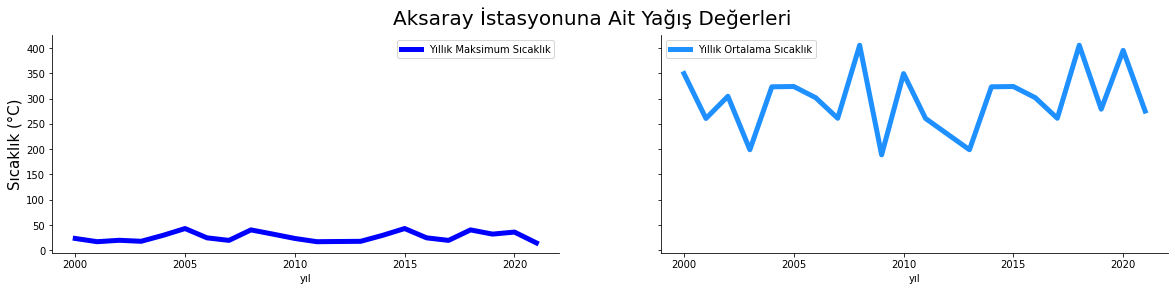

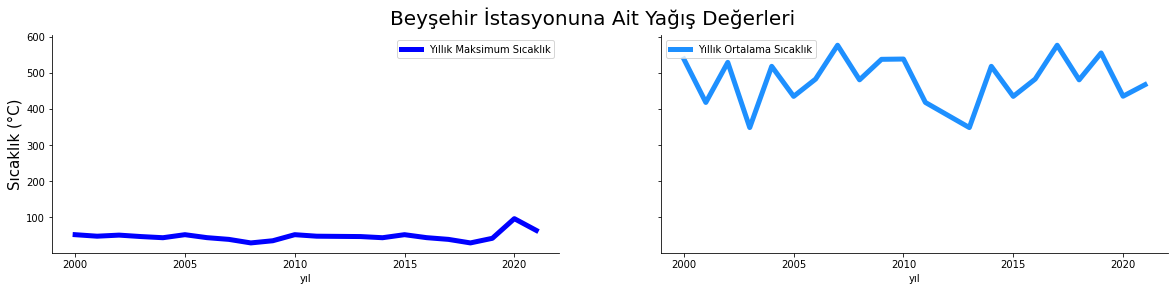

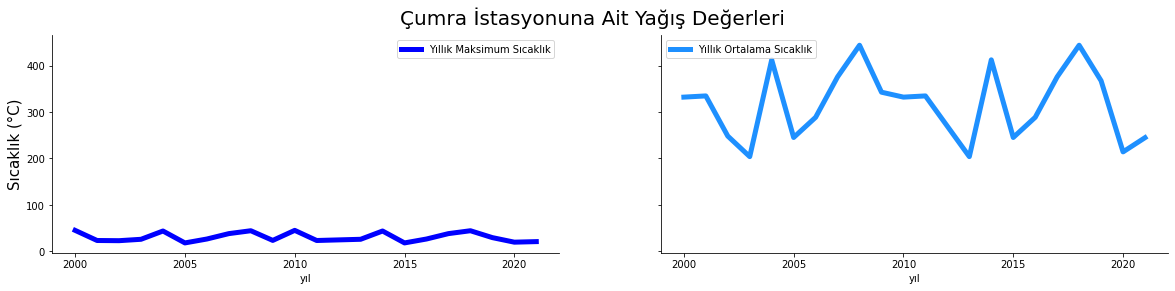

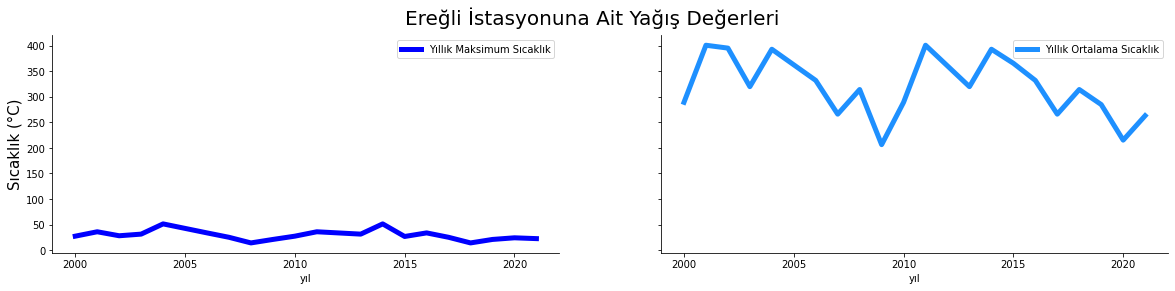

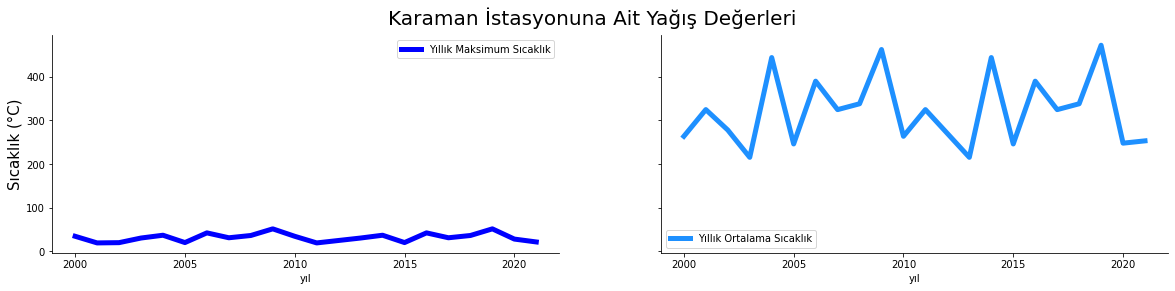

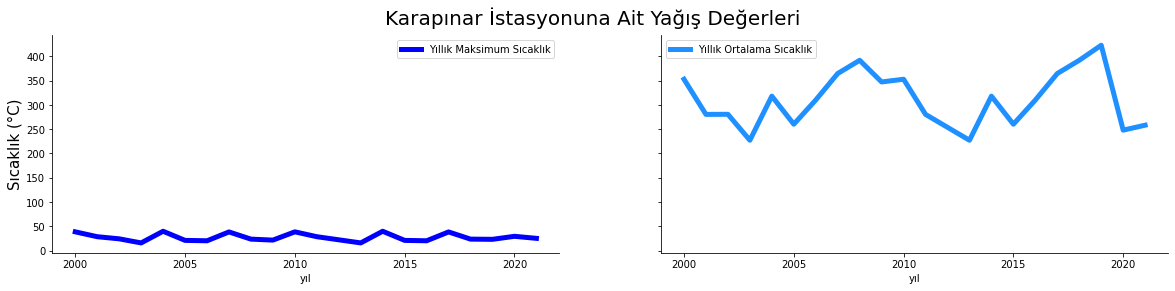

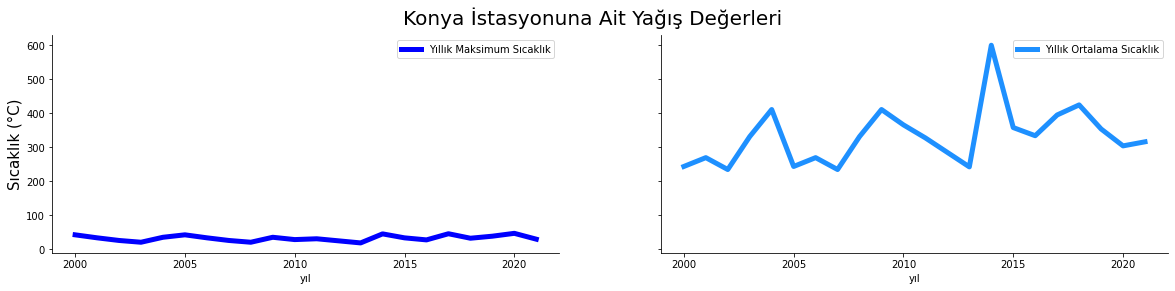

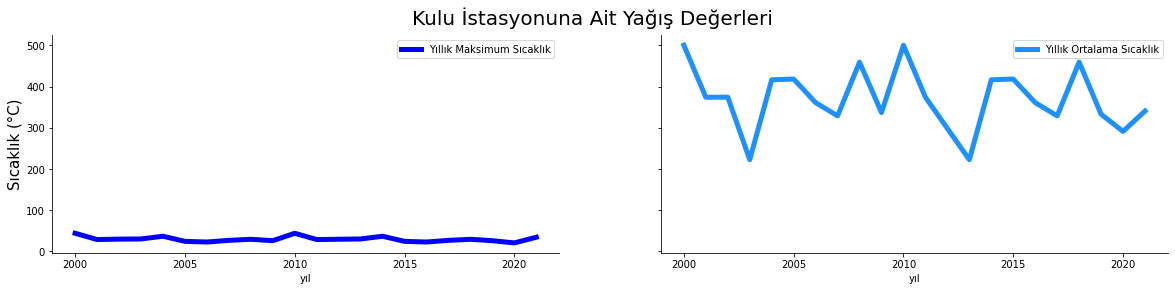

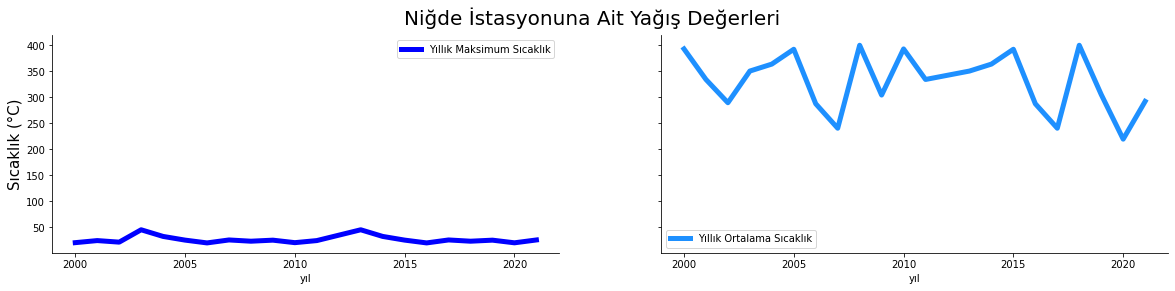

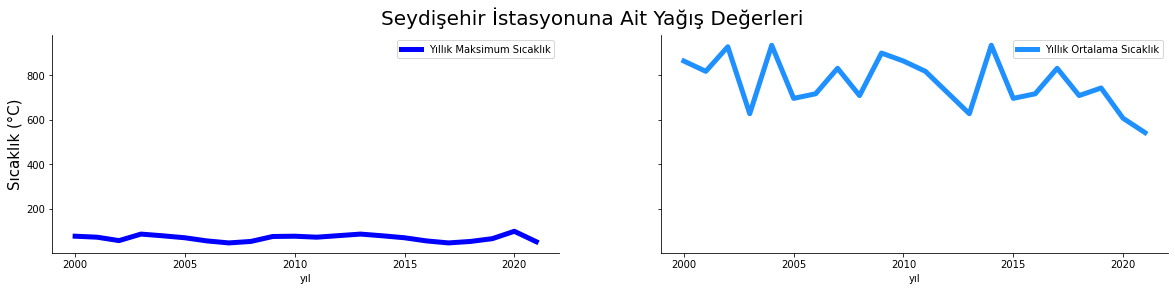

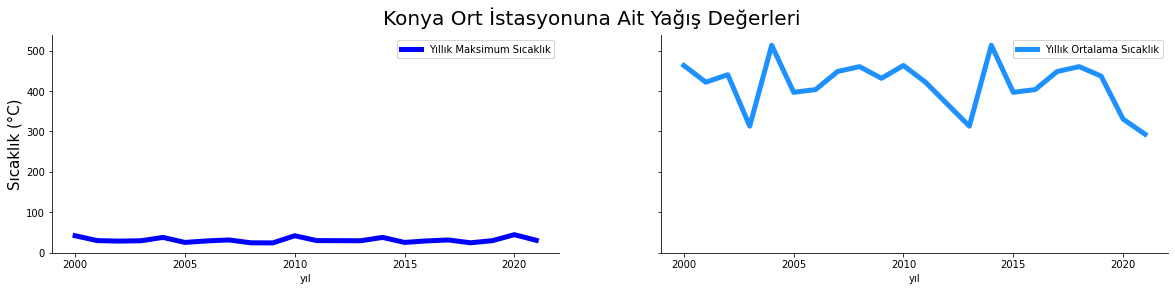

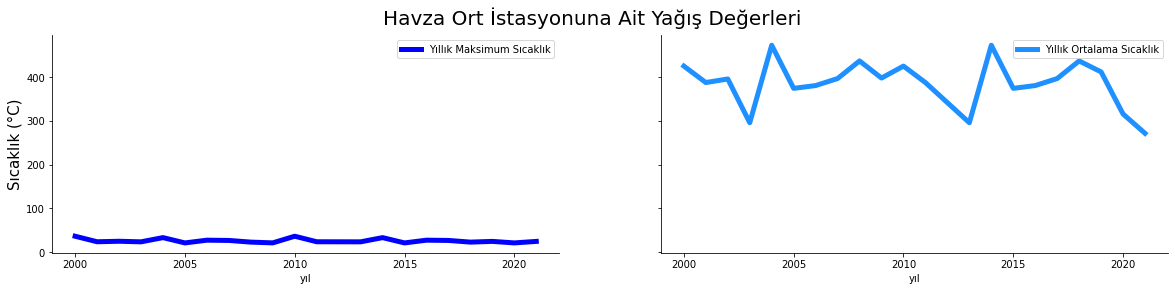

In [39]:
plotyag("Aksaray", ndviaks)
plotyag("Beyşehir", ndvibey)
plotyag("Çumra", ndvicum)
plotyag("Ereğli", ndviere)
plotyag("Karaman", ndvikrm)
plotyag("Karapınar", ndvikrp)
plotyag("Konya", ndvikon)
plotyag("Kulu", ndvikul)
plotyag("Niğde", ndvinig)
plotyag("Seydişehir", ndvisey)
plotyag("Konya Ort", ndvikor)
plotyag("Havza Ort", ndvihav)

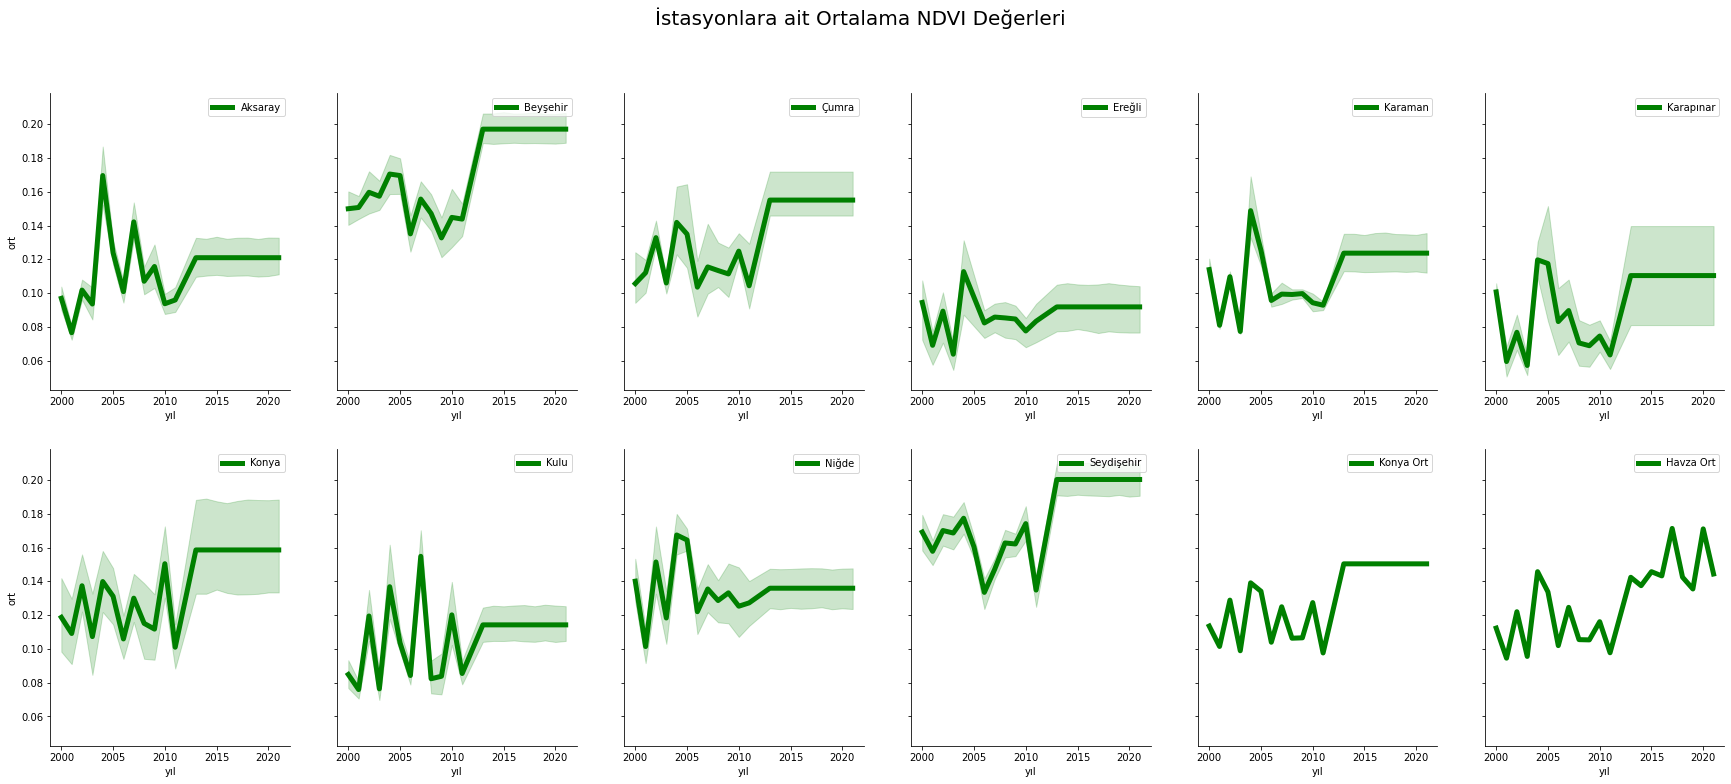

In [40]:
fig, axs = plt.subplots(2, 6, figsize=(30, 12), sharey=True)
sns.lineplot(x = "yıl", y = "ort", linewidth = 5, data = ndviaks, label = "Aksaray", color = "green", ax = axs[0][0]) 
sns.lineplot(x = "yıl", y = "ort", data = ndvibey, linewidth = 5, label = "Beyşehir", color = "green", ax = axs[0][1])
sns.lineplot(x = "yıl", y = "ort", data = ndvicum, linewidth = 5, label = "Çumra", color = "green", ax = axs[0][2])
sns.lineplot(x = "yıl", y = "ort", data = ndviere, linewidth = 5, label = "Ereğli", color = "green", ax = axs[0][3])
sns.lineplot(x = "yıl", y = "ort", data = ndvikrm, linewidth = 5, label = "Karaman", color = "green", ax = axs[0][4])
sns.lineplot(x = "yıl", y = "ort", data = ndvikrp, linewidth = 5, label = "Karapınar", color = "green", ax = axs[0][5])

sns.lineplot(x = "yıl", y = "ort", linewidth = 5, data = ndvikon, label = "Konya", color = "green", ax = axs[1][0]) 
sns.lineplot(x = "yıl", y = "ort", data = ndvikul, linewidth = 5, label = "Kulu", color = "green", ax = axs[1][1])
sns.lineplot(x = "yıl", y = "ort", data = ndvinig, linewidth = 5, label = "Niğde", color = "green", ax = axs[1][2])
sns.lineplot(x = "yıl", y = "ort", data = ndvisey, linewidth = 5, label = "Seydişehir", color = "green", ax = axs[1][3])
sns.lineplot(x = "yıl", y = "ort", data = ndvikor, linewidth = 5, label = "Konya Ort", color = "green", ax = axs[1][4])
sns.lineplot(x = "yıl", y = "ort", data = ndvihav, linewidth = 5, label = "Havza Ort", color = "green", ax = axs[1][5])

fig.suptitle("İstasyonlara ait Ortalama NDVI Değerleri", fontsize=20)
sns.despine()
plt.show()

In [41]:
yeni_ndvi_df = pd.concat([ndviaks, ndvibey, ndvicum, ndviere, ndvihav, ndvikrm, ndvikrp, ndvikor, ndvikon, ndvikul, ndvinig, ndvisey])
yeni_ndvi_df

,yer,yıl,ort,std,kat1,kat2,kat3,ist,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag
834,Sultanhani,2000,0.084135,0.053374,95.961188,4.038812,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
804,Acigol,2000,0.080301,0.028752,99.359200,0.640800,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
815,Ortakoy,2000,0.109988,0.038453,96.899962,3.100038,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
846,Guzelyurt,2000,0.108092,0.055019,92.829681,7.170319,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
848,Gulagac,2000,0.089740,0.062419,93.006532,6.993468,0.000000,Aksaray,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,Akseki,2021,0.214315,0.056597,39.184315,60.815685,0.000000,Seydişehir,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0
759,Ahirli,2021,0.187186,0.050612,65.939816,34.060184,0.000000,Seydişehir,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0
766,Bozkir,2021,0.179711,0.050496,71.385608,28.614219,0.000173,Seydişehir,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0
99,Antalya_il,2021,0.198676,0.051298,52.438381,47.561619,0.000000,Seydişehir,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0


In [42]:
yeni_ndvi_df[yeni_ndvi_df.ist == "Konya"]

,yer,yıl,ort,std,kat1,kat2,kat3,ist,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag
814,Meram,2000,0.131631,0.067108,86.197294,13.800568,0.002138,Konya,17.625,10.858333,17.625,40.6,-18.2,41.8,243.0
822,Selcuklu,2000,0.101262,0.047512,95.602583,4.397112,0.000305,Konya,17.625,10.858333,17.625,40.6,-18.2,41.8,243.0
824,Kadinhani,2000,0.146853,0.047250,87.724289,12.275711,0.000000,Konya,17.625,10.858333,17.625,40.6,-18.2,41.8,243.0
828,Sarayonu,2000,0.081160,0.029208,99.228180,0.771820,0.000000,Konya,17.625,10.858333,17.625,40.6,-18.2,41.8,243.0
847,Altinekin,2000,0.090141,0.054765,95.070697,4.926805,0.002498,Konya,17.625,10.858333,17.625,40.6,-18.2,41.8,243.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,Kadinhani,2021,0.181694,0.043374,71.706783,28.293217,0.000000,Konya,18.725,12.475000,18.725,36.9,-18.9,29.0,315.6
772,Altinekin,2021,0.138493,0.078980,86.600832,13.124849,0.274319,Konya,18.725,12.475000,18.725,36.9,-18.9,29.0,315.6
787,Selcuklu,2021,0.135149,0.055765,87.631018,12.367103,0.001879,Konya,18.725,12.475000,18.725,36.9,-18.9,29.0,315.6
795,Sarayonu,2021,0.111634,0.037406,97.659796,2.336469,0.003735,Konya,18.725,12.475000,18.725,36.9,-18.9,29.0,315.6


In [43]:
yeni_ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1584 entries, 834 to 803
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yer         1584 non-null   object 
 1   yıl         1584 non-null   int64  
 2   ort         1584 non-null   float64
 3   std         1584 non-null   float64
 4   kat1        1584 non-null   float64
 5   kat2        1584 non-null   float64
 6   kat3        1584 non-null   float64
 7   ist         1584 non-null   object 
 8   ortmax_sic  1584 non-null   float64
 9   ort_sic     1584 non-null   float64
 10  ortmin_sic  1584 non-null   float64
 11  max_sic     1584 non-null   float64
 12  min_sic     1584 non-null   float64
 13  max_yag     1584 non-null   float64
 14  top_yag     1584 non-null   float64
dtypes: float64(12), int64(1), object(2)
memory usage: 198.0+ KB


In [44]:
yeni_ndvi_df = yeni_ndvi_df.reset_index().drop(columns=["index"])
istasyon = pd.get_dummies(yeni_ndvi_df.ist)
istasyon = istasyon.rename(columns={"Aksaray":"Aksaray_ist", "Beysehir":"Beysehir_ist", "Ereğli":"Ereğli_ist", "Havza Ort":"Havza_Ort_ist",
                                    "Konya":"Konya_ist", "Konya Ort": "Konya_Ort_ist", "Kulu":"Kulu_ist", "Niğde":"Niğde_ist", "Seydişehir":"Seydişehir_ist",
                                    "Çumra":"Çumra_ist", "Karaman":"Karaman_ist", "Karapınar":"Karapınar_ist"})
yerler = pd.get_dummies(yeni_ndvi_df.yer)
yeni_ndvi_df = pd.concat([yeni_ndvi_df, istasyon, yerler],axis=1)
yeni_ndvi_df.drop(columns=['ist', 'yer'], inplace=True)
yeni_ndvi_df

,yıl,ort,std,kat1,kat2,kat3,ortmax_sic,ort_sic,ortmin_sic,max_sic,...,Seydisehir,Silifke,Sultanhani,Sutculer,Toroslar,Ulukisla,Urgup,Yalihuyuk,Yalvac,Yenisarbademli
0,2000,0.084135,0.053374,95.961188,4.038812,0.000000,17.791667,11.525000,5.433333,40.0,...,0,0,1,0,0,0,0,0,0,0
1,2000,0.080301,0.028752,99.359200,0.640800,0.000000,17.791667,11.525000,5.433333,40.0,...,0,0,0,0,0,0,0,0,0,0
2,2000,0.109988,0.038453,96.899962,3.100038,0.000000,17.791667,11.525000,5.433333,40.0,...,0,0,0,0,0,0,0,0,0,0
3,2000,0.108092,0.055019,92.829681,7.170319,0.000000,17.791667,11.525000,5.433333,40.0,...,0,0,0,0,0,0,0,0,0,0
4,2000,0.089740,0.062419,93.006532,6.993468,0.000000,17.791667,11.525000,5.433333,40.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,2021,0.214315,0.056597,39.184315,60.815685,0.000000,19.525000,12.816667,19.525000,36.6,...,0,0,0,0,0,0,0,0,0,0
1580,2021,0.187186,0.050612,65.939816,34.060184,0.000000,19.525000,12.816667,19.525000,36.6,...,0,0,0,0,0,0,0,0,0,0
1581,2021,0.179711,0.050496,71.385608,28.614219,0.000173,19.525000,12.816667,19.525000,36.6,...,0,0,0,0,0,0,0,0,0,0
1582,2021,0.198676,0.051298,52.438381,47.561619,0.000000,19.525000,12.816667,19.525000,36.6,...,0,0,0,0,0,0,0,0,0,0


In [45]:
yeni_ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Columns: 101 entries, yıl to Yenisarbademli
dtypes: float64(12), int64(1), uint8(88)
memory usage: 297.1 KB


In [46]:
yerlist = list(yerler.columns)

In [47]:
val_df = pd.read_csv("../input/jupyterdemeteorolojik-regresoyn/validation.csv")
val_df.drop(columns=["Unnamed: 0", "index"], inplace=True)
val_df.head()

,yıl,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,Aksaray,Beysehir,Ereğli,Havza Ort,Karaman,Karapınar,Konya,Konya Ort,Kulu,Niğde,Seydişehir,Çumra
0,2022,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,1,0,0,0,0,0,0,0,0,0,0,0
1,2022,35.864461,17.817349,11.365267,-17.580371,18.359058,54.831714,528.683665,0,1,0,0,0,0,0,0,0,0,0,0
2,2022,37.796561,18.823329,12.040909,-17.924900,19.030292,27.419800,250.031130,0,0,0,0,0,0,0,0,0,0,0,1
3,2022,37.868403,19.930642,13.241490,-18.825700,19.848815,23.850729,272.956381,0,0,1,0,0,0,0,0,0,0,0,0
4,2022,37.045865,19.341121,12.217591,-17.348700,15.403317,24.736214,292.346316,0,0,0,1,0,0,0,0,0,0,0,0


In [48]:
mgm_aks = val_df[val_df.Aksaray == 1]
mgm_bey = val_df[val_df.Beysehir == 1]
mgm_cum = val_df[val_df.Çumra == 1]
mgm_ere = val_df[val_df.Ereğli == 1]
mgm_hav = val_df[val_df["Havza Ort"] == 1]
mgm_krm = val_df[val_df.Karaman == 1]
mgm_krp = val_df[val_df.Karapınar == 1]
mgm_kon = val_df[val_df.Konya == 1]
mgm_kor = val_df[val_df["Konya Ort"] == 1]
mgm_kul = val_df[val_df.Kulu == 1]
mgm_nig = val_df[val_df.Niğde == 1]
mgm_sey = val_df[val_df.Seydişehir == 1]

mgm_aks

,yıl,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,Aksaray,Beysehir,Ereğli,Havza Ort,Karaman,Karapınar,Konya,Konya Ort,Kulu,Niğde,Seydişehir,Çumra
0,2022,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,1,0,0,0,0,0,0,0,0,0,0,0
12,2023,37.334345,19.392808,12.890515,-17.248529,6.256373,28.201465,337.539086,1,0,0,0,0,0,0,0,0,0,0,0
24,2024,37.159795,19.126957,12.931339,-17.789814,6.189527,29.700862,345.382800,1,0,0,0,0,0,0,0,0,0,0,0
36,2025,37.159795,19.063689,12.792895,-17.709957,6.189527,29.275988,348.307714,1,0,0,0,0,0,0,0,0,0,0,0
48,2026,37.159795,18.859530,12.792895,-17.802214,6.488273,31.094226,348.285514,1,0,0,0,0,0,0,0,0,0,0,0


In [49]:
validation = pd.DataFrame({"yer":[y for a in range(2022,2027) for y in yerlist], "yıl": [a for a in range(2022,2027) for y in yerlist]})
yakin_ist_list = []
for i, r in validation.iterrows():
    for j, k in yer_df.iterrows():
        if r["yer"] == k["yer"]:
            yakin_ist_list.append(k["yakin_ist"])
        
validation["ist"] = yakin_ist_list
validation

,yer,yıl,ist
0,Acigol,2022,Aksaray
1,Agacoren,2022,Aksaray
2,Ahirli,2022,Seydisehir
3,Akoren,2022,Cumra
4,Aksaray,2022,Aksaray
...,...,...,...
375,Ulukisla,2026,Eregli
376,Urgup,2026,Nigde
377,Yalihuyuk,2026,Seydisehir
378,Yalvac,2026,Beysehir


In [50]:
valaks = validation[validation["ist"] == "Aksaray"].sort_values(by=["yıl"])
valbey = validation[validation["ist"] == "Beysehir"].sort_values(by=["yıl"])
valcum = validation[validation["ist"] == "Cumra"].sort_values(by=["yıl"])
valere = validation[validation["ist"] == "Eregli"].sort_values(by=["yıl"])
valhav = validation[validation["ist"] == "HAVZA_ORT"].sort_values(by=["yıl"])
valkrm = validation[validation["ist"] == "Karaman"].sort_values(by=["yıl"])
valkrp = validation[validation["ist"] == "Karapinar"].sort_values(by=["yıl"])
valkor = validation[validation["ist"] == "KONYA_ORT"].sort_values(by=["yıl"])
valkon = validation[validation["ist"] == "Konya"].sort_values(by=["yıl"])
valkul = validation[validation["ist"] == "Kulu"].sort_values(by=["yıl"])
valnig = validation[validation["ist"] == "Nigde"].sort_values(by=["yıl"])
valsey = validation[validation["ist"] == "Seydisehir"].sort_values(by=["yıl"])

valaks

,yer,yıl,ist
0,Acigol,2022,Aksaray
1,Agacoren,2022,Aksaray
4,Aksaray,2022,Aksaray
5,Aksaray_il,2022,Aksaray
30,Eskil,2022,Aksaray
34,Gulagac,2022,Aksaray
36,Guzelyurt,2022,Aksaray
60,Ortakoy,2022,Aksaray
62,Sariyahsi,2022,Aksaray
68,Sultanhani,2022,Aksaray


In [51]:
def val_column_adder(indf, outdf):
    allst = []
    for i in indf.drop(columns="yıl"):
        for year in range(2022,2027):
            count_year = len(outdf[outdf["yıl"] == year])
            lst = list(indf.loc[indf["yıl"] == year][i])*count_year
            allst.extend(lst)
        outdf[i] = allst
        allst = []

In [52]:
val_column_adder(mgm_aks, valaks)
val_column_adder(mgm_bey, valbey)
val_column_adder(mgm_cum, valcum)
val_column_adder(mgm_ere, valere)
val_column_adder(mgm_hav, valhav)
val_column_adder(mgm_kor, valkor)
val_column_adder(mgm_kon, valkon)
val_column_adder(mgm_kul, valkul)
val_column_adder(mgm_krm, valkrm)
val_column_adder(mgm_krp, valkrp)
val_column_adder(mgm_nig, valnig)
val_column_adder(mgm_sey, valsey)

valaks

,yer,yıl,ist,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,...,Ereğli,Havza Ort,Karaman,Karapınar,Konya,Konya Ort,Kulu,Niğde,Seydişehir,Çumra
0,Acigol,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
1,Agacoren,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
4,Aksaray,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
5,Aksaray_il,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
30,Eskil,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
34,Gulagac,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
36,Guzelyurt,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
60,Ortakoy,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
62,Sariyahsi,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
68,Sultanhani,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0


In [53]:
validation = pd.concat([valaks, valbey, valcum, valere, valhav, valkor, valkon, valnig, valsey, valkrm, valkrp, valkul], ignore_index=True)
validation

,yer,yıl,ist,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,...,Ereğli,Havza Ort,Karaman,Karapınar,Konya,Konya Ort,Kulu,Niğde,Seydişehir,Çumra
0,Acigol,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
1,Agacoren,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
2,Aksaray,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
3,Aksaray_il,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
4,Eskil,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Cihanbeyli,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,1,0,0,0
376,Evren,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,1,0,0,0
377,Golbasi,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,1,0,0,0
378,Haymana,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,1,0,0,0


In [54]:
"""istlist = []
istler = ["Aksaray", "Beysehir", "Ereğli", "Havza Ort", "Karaman", "Karapınar", "Konya", "Konya Ort", "Kulu", "Niğde", 
          "Seydişehir", "Çumra"]
for _, i in validation[istler].iterrows():
    for j in istler:
        if i[j] == 1:
            istlist.append(j)
            
validation["ist"] = istlist
validation.drop(columns=istler, inplace=True)
validation"""

'istlist = []\nistler = ["Aksaray", "Beysehir", "Ereğli", "Havza Ort", "Karaman", "Karapınar", "Konya", "Konya Ort", "Kulu", "Niğde", \n          "Seydişehir", "Çumra"]\nfor _, i in validation[istler].iterrows():\n    for j in istler:\n        if i[j] == 1:\n            istlist.append(j)\n            \nvalidation["ist"] = istlist\nvalidation.drop(columns=istler, inplace=True)\nvalidation'

In [55]:
"""validation = validation.reset_index().drop(columns=["index"])
istasyon = pd.get_dummies(validation.ist)"""
validation = validation.rename(columns={"Aksaray":"Aksaray_ist", "Beysehir":"Beysehir_ist", "Ereğli":"Ereğli_ist", "Havza Ort":"Havza_Ort_ist",
                                    "Konya":"Konya_ist", "Konya Ort": "Konya_Ort_ist", "Kulu":"Kulu_ist", "Niğde":"Niğde_ist", "Seydişehir":"Seydişehir_ist",
                                    "Çumra":"Çumra_ist", "Karaman":"Karaman_ist", "Karapınar":"Karapınar_ist"})
yerler = pd.get_dummies(validation.yer)
validation = pd.concat([validation, yerler],axis=1)
#validation.drop(columns=['ist', 'yer'], inplace=True)
validation

,yer,yıl,ist,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,...,Seydisehir,Silifke,Sultanhani,Sutculer,Toroslar,Ulukisla,Urgup,Yalihuyuk,Yalvac,Yenisarbademli
0,Acigol,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
1,Agacoren,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
2,Aksaray,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
3,Aksaray_il,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
4,Eskil,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Cihanbeyli,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0
376,Evren,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0
377,Golbasi,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0
378,Haymana,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0


In [56]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 98 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yer              380 non-null    object 
 1   yıl              380 non-null    int64  
 2   ist              380 non-null    object 
 3   max_sic          380 non-null    float64
 4   ortmax_sic       380 non-null    float64
 5   ort_sic          380 non-null    float64
 6   min_sic          380 non-null    float64
 7   ortmin_sic       380 non-null    float64
 8   max_yag          380 non-null    float64
 9   top_yag          380 non-null    float64
 10  Aksaray_ist      380 non-null    int64  
 11  Beysehir_ist     380 non-null    int64  
 12  Ereğli_ist       380 non-null    int64  
 13  Havza_Ort_ist    380 non-null    int64  
 14  Karaman_ist      380 non-null    int64  
 15  Karapınar_ist    380 non-null    int64  
 16  Konya_ist        380 non-null    int64  
 17  Konya_Ort_ist   

In [57]:
yeni_ndvi_df.isnull().sum().sum()

0

In [58]:
validation.isnull().sum().sum()

0

In [59]:
yeni_ndvi_df.drop(columns=["std", "kat1", "kat2", "kat3"], inplace = True)

# Regresyon

In [60]:
X = yeni_ndvi_df.drop(columns="ort")
y = yeni_ndvi_df["ort"]

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 96 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yıl              1584 non-null   int64  
 1   ortmax_sic       1584 non-null   float64
 2   ort_sic          1584 non-null   float64
 3   ortmin_sic       1584 non-null   float64
 4   max_sic          1584 non-null   float64
 5   min_sic          1584 non-null   float64
 6   max_yag          1584 non-null   float64
 7   top_yag          1584 non-null   float64
 8   Aksaray_ist      1584 non-null   uint8  
 9   Beysehir_ist     1584 non-null   uint8  
 10  Ereğli_ist       1584 non-null   uint8  
 11  Havza_Ort_ist    1584 non-null   uint8  
 12  Karaman_ist      1584 non-null   uint8  
 13  Karapınar_ist    1584 non-null   uint8  
 14  Konya_ist        1584 non-null   uint8  
 15  Konya_Ort_ist    1584 non-null   uint8  
 16  Kulu_ist         1584 non-null   uint8  
 17  Niğde_ist     

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

linearmodel = LinearRegression()
rfmodel = RandomForestRegressor()
gradmodel = GradientBoostingRegressor()

R kare: 0.6896772600244323, MAE: 0.01594518641130168


<AxesSubplot:ylabel='Density'>

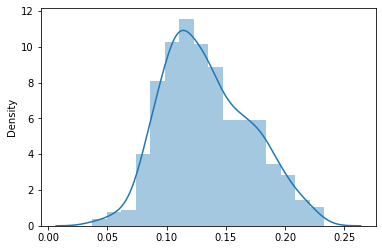

In [63]:
linearmodel.fit(X_train, y_train)
pred_lin = linearmodel.predict(X_test)
print("R kare: {}, MAE: {}".format(r2_score(y_test, pred_lin), mean_absolute_error(y_test, pred_lin)))
combined = pd.concat([y_test, pd.Series(pred_lin, index=y_test.index)], axis=1)
combined.columns = ["gercek", "tahmin"]
sns.distplot(combined)

R kare: 0.844360367358751, MAE: 0.009437585719211357


<AxesSubplot:ylabel='Density'>

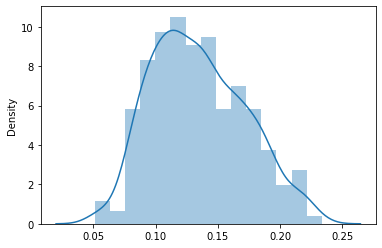

In [64]:
rfmodel.fit(X_train, y_train)
pred_rf = rfmodel.predict(X_test)
print("R kare: {}, MAE: {}".format(r2_score(y_test, pred_rf), mean_absolute_error(y_test, pred_rf)))
combined = pd.concat([y_test, pd.Series(pred_rf, index=y_test.index)], axis=1)
combined.columns = ["gercek", "tahmin"]
sns.distplot(combined)

R kare: 0.7534726650337179, MAE: 0.014582272133039718


<AxesSubplot:ylabel='Density'>

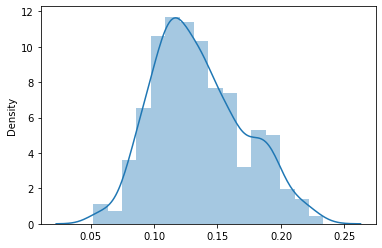

In [65]:
gradmodel.fit(X_train, y_train)
pred_grad = gradmodel.predict(X_test)
print("R kare: {}, MAE: {}".format(r2_score(y_test, pred_grad), mean_absolute_error(y_test, pred_grad)))
combined = pd.concat([y_test, pd.Series(pred_grad, index=y_test.index)], axis=1)
combined.columns = ["gercek", "tahmin"]
sns.distplot(combined)

In [66]:
pred_val = rfmodel.predict(validation.drop(columns=["yer", "ist"]))
validation["ort"] = pred_val
validation

,yer,yıl,ist,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,...,Silifke,Sultanhani,Sutculer,Toroslar,Ulukisla,Urgup,Yalihuyuk,Yalvac,Yenisarbademli,ort
0,Acigol,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0.114508
1,Agacoren,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0.125699
2,Aksaray,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0.124266
3,Aksaray_il,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0.136040
4,Eskil,2022,Aksaray,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,...,0,0,0,0,0,0,0,0,0,0.140101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Cihanbeyli,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0.119022
376,Evren,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0.121691
377,Golbasi,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0.124545
378,Haymana,2026,Kulu,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,...,0,0,0,0,0,0,0,0,0,0.143303


In [67]:
yerlist

['Acigol',
 'Agacoren',
 'Ahirli',
 'Akoren',
 'Aksaray',
 'Aksaray_il',
 'Akseki',
 'Aksu',
 'Altinekin',
 'Altunhisar',
 'Ankara_il',
 'Antalya_il',
 'Ayranci',
 'Bala',
 'Beysehir',
 'Bor',
 'Bozkir',
 'Camardi',
 'Camliyayla',
 'Ciftlik',
 'Cihanbeyli',
 'Cumra',
 'Derbent',
 'Derebucak',
 'Derinkuyu',
 'Doganhisar',
 'Egirdir',
 'Emirgazi',
 'Erdemli',
 'Eregli',
 'Eskil',
 'Evren',
 'Gelendost',
 'Golbasi',
 'Gulagac',
 'Guneysinir',
 'Guzelyurt',
 'Halkapinar',
 'Havza',
 'Haymana',
 'Huyuk',
 'Ibradi',
 'Ilgin',
 'Isparta_il',
 'Kadinhani',
 'Karaman',
 'Karaman_il',
 'Karapinar',
 'Karatay',
 'Kazimkarabekir',
 'Konya_il',
 'Kulu',
 'Manavgat',
 'Meram',
 'Mersin_il',
 'Mut',
 'Nevsehir',
 'Nevsehir_il',
 'Nigde',
 'Nigde_il',
 'Ortakoy',
 'Sarayonu',
 'Sariyahsi',
 'Sarkikaraagac',
 'Selcuklu',
 'Sereflikochisar',
 'Seydisehir',
 'Silifke',
 'Sultanhani',
 'Sutculer',
 'Toroslar',
 'Ulukisla',
 'Urgup',
 'Yalihuyuk',
 'Yalvac',
 'Yenisarbademli']

In [68]:
istlist = []
istler = ["Aksaray_ist", "Beysehir_ist", "Ereğli_ist", "Havza_Ort_ist", "Karaman_ist", "Karapınar_ist", "Konya_ist", "Konya_Ort_ist", "Kulu_ist", "Niğde_ist", 
          "Seydişehir_ist", "Çumra_ist"]
for _, i in validation[istler].iterrows():
    for j in istler:
        if i[j] == 1:
            istlist.append(j)
            
validation["ist"] = istlist
validation.drop(columns=istler, inplace=True)

In [69]:
yerler = []
for _, i in validation[yerlist].iterrows():
    for j in yerlist:
        if i[j] == 1:
            yerler.append(j)

validation["yer"] = yerler
validation.drop(columns=yerlist, inplace=True)
validation

,yer,yıl,ist,max_sic,ortmax_sic,ort_sic,min_sic,ortmin_sic,max_yag,top_yag,ort
0,Acigol,2022,Aksaray_ist,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,0.114508
1,Agacoren,2022,Aksaray_ist,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,0.125699
2,Aksaray,2022,Aksaray_ist,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,0.124266
3,Aksaray_il,2022,Aksaray_ist,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,0.136040
4,Eskil,2022,Aksaray_ist,37.670836,19.473885,12.830510,-18.438600,6.320528,27.396600,255.362590,0.140101
...,...,...,...,...,...,...,...,...,...,...,...
375,Cihanbeyli,2026,Kulu_ist,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,0.119022
376,Evren,2026,Kulu_ist,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,0.121691
377,Golbasi,2026,Kulu_ist,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,0.124545
378,Haymana,2026,Kulu_ist,37.244220,17.918444,10.997716,-17.635429,18.297049,30.399741,355.763971,0.143303


In [70]:
yeni_ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 97 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yıl              1584 non-null   int64  
 1   ort              1584 non-null   float64
 2   ortmax_sic       1584 non-null   float64
 3   ort_sic          1584 non-null   float64
 4   ortmin_sic       1584 non-null   float64
 5   max_sic          1584 non-null   float64
 6   min_sic          1584 non-null   float64
 7   max_yag          1584 non-null   float64
 8   top_yag          1584 non-null   float64
 9   Aksaray_ist      1584 non-null   uint8  
 10  Beysehir_ist     1584 non-null   uint8  
 11  Ereğli_ist       1584 non-null   uint8  
 12  Havza_Ort_ist    1584 non-null   uint8  
 13  Karaman_ist      1584 non-null   uint8  
 14  Karapınar_ist    1584 non-null   uint8  
 15  Konya_ist        1584 non-null   uint8  
 16  Konya_Ort_ist    1584 non-null   uint8  
 17  Kulu_ist      

In [71]:
istlist = []
istler = ["Aksaray_ist", "Beysehir_ist", "Ereğli_ist", "Havza_Ort_ist", "Karaman_ist", "Karapınar_ist", "Konya_ist", "Konya_Ort_ist", "Kulu_ist", "Niğde_ist", 
          "Seydişehir_ist", "Çumra_ist"]
for _, i in yeni_ndvi_df[istler].iterrows():
    for j in istler:
        if i[j] == 1:
            istlist.append(j)
            
yeni_ndvi_df["ist"] = istlist
yeni_ndvi_df.drop(columns=istler, inplace=True)

yerler = []
for _, i in yeni_ndvi_df[yerlist].iterrows():
    for j in yerlist:
        if i[j] == 1:
            yerler.append(j)

yeni_ndvi_df["yer"] = yerler
yeni_ndvi_df.drop(columns=yerlist, inplace=True)
yeni_ndvi_df

,yıl,ort,ortmax_sic,ort_sic,ortmin_sic,max_sic,min_sic,max_yag,top_yag,ist,yer
0,2000,0.084135,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,Aksaray_ist,Sultanhani
1,2000,0.080301,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,Aksaray_ist,Acigol
2,2000,0.109988,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,Aksaray_ist,Ortakoy
3,2000,0.108092,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,Aksaray_ist,Guzelyurt
4,2000,0.089740,17.791667,11.525000,5.433333,40.0,-16.0,23.6,349.2,Aksaray_ist,Gulagac
...,...,...,...,...,...,...,...,...,...,...,...
1579,2021,0.214315,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0,Seydişehir_ist,Akseki
1580,2021,0.187186,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0,Seydişehir_ist,Ahirli
1581,2021,0.179711,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0,Seydişehir_ist,Bozkir
1582,2021,0.198676,19.525000,12.816667,19.525000,36.6,-15.9,50.4,542.0,Seydişehir_ist,Antalya_il


In [72]:
validation.to_csv("./tahmini_table.csv")
yeni_ndvi_df.to_csv("./gercek_table.csv")

<AxesSubplot:>

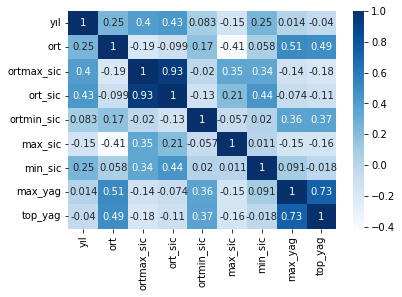

In [73]:
sns.heatmap(yeni_ndvi_df.corr(), cmap="Blues", annot=True)